<font size=6> <b> SMU Lab Three - MSDS7331 - Machine Learning-1 </b> </font>

<font size=5> <b> Summer 2020 Group - Sachin, Ikenna, Edgar, Dustin </b></font> 




<img src="https://github.com/sachinac/ML7331/blob/master/data/maxresdefault.png?raw=true"> 

<p align="center"><font size=5> <b> Movie Recommender System  </b></font> </p>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1">Import Libraries</a></span></li><li><span><a href="#Business-Understanding-1" data-toc-modified-id="Business-Understanding-1-2">Business Understanding 1</a></span></li><li><span><a href="#Data-Understanding-1" data-toc-modified-id="Data-Understanding-1-3">Data Understanding 1</a></span></li><li><span><a href="#Data-Understanding-2" data-toc-modified-id="Data-Understanding-2-4">Data Understanding 2</a></span></li><li><span><a href="#Model-and-Evaluations-1" data-toc-modified-id="Model-and-Evaluations-1-5">Model and Evaluations 1</a></span></li><li><span><a href="#Model-and-Evaluations-2" data-toc-modified-id="Model-and-Evaluations-2-6">Model and Evaluations 2</a></span></li><li><span><a href="#Model-and-Evaluations-3" data-toc-modified-id="Model-and-Evaluations-3-7">Model and Evaluations 3</a></span></li><li><span><a href="#Model-and-Evaluations-4" data-toc-modified-id="Model-and-Evaluations-4-8">Model and Evaluations 4</a></span></li><li><span><a href="#Deployment" data-toc-modified-id="Deployment-9">Deployment</a></span></li><li><span><a href="#Exceptional-Work" data-toc-modified-id="Exceptional-Work-10">Exceptional Work</a></span></li><li><span><a href="#References" data-toc-modified-id="References-11">References</a></span></li></ul></div>

# Import Libraries

In [314]:
import pandas as pd
import numpy as np
import turicreate as tc
import ast
import wget
import zipfile
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer

timebreak = '\n\n----------------------------------------------------\nCell Processing Time'

# Business Understanding

We wanted to build a movie recommendation system that would go a bit deeper than the traditional grouplens movie ratings dataset.  In this notebook, we will be utilizing the popular movies dataset comprised of 26 million movie ratings from the GroupLens website, but with additional augmented data from TMDB which provides details including more detailed movie metadata such as: cast, crew, budget, country, revenue, languages and plot keywords on approximately 45,000 movies released prior to August 2017.

We will explore various methods for recommending movies to users based on content based and collaborative filtering methods. Because movie taste is highly subjective, it may prove difficult to measure the effectiveness of our algorithms, but we will capture Root Mean Square Errored (RMSE) to compare predicted vs actual ratings for items.  We will also look at precision and recall for per-user and per-item metrics, as well as calculating metrics in different ways such as by genre or country or origin.



# Data Understanding 1 - First Impressions


## Downloading the data:
Because the unzipped data is ~ 900mb, we've saved it in an AWS S3 bucket as a zip file.  We've added the movies data directory to our *.gitignore* file so it doesn't get picked up in github.  This chunk of code does the following:
* Check if the movie directory exists, create it if not, skip the step if so.  
* Checks files in the directory against expected files, if not found, download the zip file from AWS, extracts and deletes the downloaded zip file, then cleans up created variables.

In [62]:
%%time
movie_dir = './data/movies'
movie_zipfile = movie_dir + '/movies.zip'
expected_files = ['keywords.csv', 'credits.csv', 'ratings.csv', 'ratings_small.csv', 'links_small.csv', 'movies_metadata.csv', 'links.csv']
movie_data = 'https://ml7331.s3.us-east-2.amazonaws.com/3405_6663_bundle_archive.zip'

# If movie directory doesn't exist, create it
if not os.path.isdir(movie_dir):
    print('creating directory:', movie_dir)
    os.mkdir(movie_dir)

# If all expected files are not present, download a fresh copy of movie data:    
if not all(files in os.listdir(movie_dir) for files in expected_files):
    print('downloading files...')
    wget.download(movie_data, movie_zipfile)
    print('unzipping files...')
    with zipfile.ZipFile(movie_zipfile, 'r') as zip_ref:
        zip_ref.extractall(movie_dir)
    os.remove(movie_zipfile)
    
del movie_data, movie_zipfile, movie_dir, expected_files
print('Movie files are present!', timebreak)

Movie files are present! 

----------------------------------------------------
Cell Processing Time
CPU times: user 1.27 ms, sys: 33 µs, total: 1.3 ms
Wall time: 690 µs


In [99]:
%%time
# Read in datasets
#TODO: these should go in their own sections eventually
links = pd.read_csv('./data/movies/links.csv')
links_small = pd.read_csv('./data/movies/links_small.csv')

links_small

CPU times: user 10.8 ms, sys: 34 µs, total: 10.8 ms
Wall time: 9.94 ms


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9120,162672,3859980,402672.0
9121,163056,4262980,315011.0
9122,163949,2531318,391698.0
9123,164977,27660,137608.0


## Movie Credits

The credits dataset (found in /data/credits.csv) has a movie id column and provides two JSON objects stored as a string representing the crew and cast.  It uses single quotes for strings, except in cases where a single quote is used, these strings are wrapped in double quotes.  Well formed JSON expects strings to be wrapped in double quotes, so we'll write a little helper function using the *literal_eval* function from the Abstract Syntax Trees package.

After parsing them as literal into a list object, we can pick out **directors, producers and actors**, which we think will be most important in influencing recommendations.  We'll save these as list objects which we can then merge into our movies dataset.

We also discovered 44 duplicate entries in this file, which from a sample of random selections appear to be true duplicates and will be safely removed.

In [69]:
%%time

credits = pd.read_csv('./data/movies/credits.csv')

# Drop rows where both cast and crew are empty
credits = credits[~((credits['cast'].str.contains('\[\]')) & (credits['crew'].str.contains('\[\]')))]

def dedupe(df):
    dupes = len(df[df.duplicated(subset=['id'])])
    print('Removed', dupes, 'duplicate rows.\n')
    return df[~df.duplicated(subset=['id'])]

# Remove duplicates:
credits = dedupe(credits)

def get_credits(crew_json):
    crew = ast.literal_eval(crew_json.crew)
    cast = ast.literal_eval(crew_json.cast)
    directors = []
    producers = []
    actors = []
    for member in crew:
        if 'Director' in member['job']:
            directors.append(member['name'])
        if 'Producer' in member['job']:
            producers.append(member['name'])
    for actor in cast:
        actors.append(actor['name'])

    return  pd.Series([directors, producers, actors])

credits[['directors','producers','actors']] = credits.apply(get_credits, axis=1)



print(credits.info(),timebreak)

credits


Removed 44 duplicate rows.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45011 entries, 0 to 45475
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   cast       45011 non-null  object
 1   crew       45011 non-null  object
 2   id         45011 non-null  int64 
 3   directors  45011 non-null  object
 4   producers  45011 non-null  object
 5   actors     45011 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.4+ MB
None 

----------------------------------------------------
Cell Processing Time
CPU times: user 36.8 s, sys: 84.1 ms, total: 36.9 s
Wall time: 36.9 s


,cast,crew,id,directors,producers,actors
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,"[John Lasseter, Ash Brannon, William Reeves, R...","[Bonnie Arnold, Ed Catmull, Ralph Guggenheim, ...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney..."
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,"[Joe Johnston, Thomas E. Ackerman]","[Larry J. Franco, Scott Kroopf, Ted Field, Rob...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,..."
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,[Howard Deutch],[],"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop..."
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,[Forest Whitaker],"[Ronald Bass, Ezra Swerdlow, Deborah Schindler...","[Whitney Houston, Angela Bassett, Loretta Devi..."
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,"[Elliot Davis, Charles Shyer]",[Nancy Meyers],"[Steve Martin, Diane Keaton, Martin Short, Kim..."
...,...,...,...,...,...,...
45471,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...",439050,"[Hamid Nematollah, Babak Ardalan]",[Hamid Nematollah],"[Leila Hatami, Kourosh Tahami, Elham Korda]"
45472,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",111109,[Lav Diaz],[],"[Angel Aquino, Perry Dizon, Hazel Orencio, Joe..."
45473,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",67758,"[Mark L. Lester, João Fernandes]",[],"[Erika Eleniak, Adam Baldwin, Julie du Page, J..."
45474,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",227506,[Yakov Protazanov],[Joseph N. Ermolieff],"[Iwan Mosschuchin, Nathalie Lissenko, Pavel Pa..."


## Movie Keywords

The keywords dataset (found in /data/keywords.csv) has a movie id column and again provides a JSON object stored as a string representing keywords which apply to each movie.  It uses single quotes for strings, except in cases where a single quote is used, these strings are wrapped in double quotes.  Well formed JSON expects strings to be wrapped in double quotes, so we'll utilize another helper function using the *literal_eval* function from the Abstract Syntax Trees package.

After parsing them as literal into a list object, and removing empty list objects, we'll save these **plot keywords** as list object which we can merge into our movies dataset.

There are 532 duplicate entries in this file which from a sample of random selections, again appear to be true duplicates and will be safely removed.

In [483]:
%%time

keywords = pd.read_csv('./data/movies/keywords.csv')

# Remove empty entries:
keywords = keywords[~keywords['keywords'].str.contains('\[\]')]

# Remove duplicates:
keywords = dedupe(keywords)

keywords['keyword_json'] = keywords['keywords'] 

# Breakout json into a list of names
def get_keywords(keyword_list):
    if keyword_list is np.nan:
        return np.nan
    kw = []
    klist = ast.literal_eval(keyword_list)
    for word in klist:
        kw.append(word['name'])
    return kw

keywords['keywords'] = keywords.keyword_json.apply(get_keywords)

print(keywords.info(),timebreak)

keywords

Removed 532 duplicate rows.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31092 entries, 0 to 46415
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            31092 non-null  int64 
 1   keywords      31092 non-null  object
 2   keyword_json  31092 non-null  object
dtypes: int64(1), object(2)
memory usage: 971.6+ KB
None 

----------------------------------------------------
Cell Processing Time
CPU times: user 1.36 s, sys: 10.2 ms, total: 1.37 s
Wall time: 1.37 s


,id,keywords,keyword_json
0,862,"[jealousy, toy, boy, friendship, friends, riva...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[board game, disappearance, based on children'...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[fishing, best friend, duringcreditsstinger, o...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[based on novel, interracial relationship, sin...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[baby, midlife crisis, confidence, aging, daug...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...,...
46409,84419,"[revenge, murder, serial killer, new york city...","[{'id': 9748, 'name': 'revenge'}, {'id': 9826,..."
46410,390959,[blair witch],"[{'id': 224180, 'name': 'blair witch'}]"
46411,289923,"[witch, mythology, legend, serial killer, mock...","[{'id': 616, 'name': 'witch'}, {'id': 2035, 'n..."
46414,439050,[tragic love],"[{'id': 10703, 'name': 'tragic love'}]"


In [479]:
#ast.literal_eval(np.nan)
np.nan

nan

In [482]:
if np.nan:
    print('nan-nan')

nan-nan


## Movie Metadata



The movies dataset (found in /data/movies_metadata.csv) has a movie id column and provides a lot of usable and JSON objects storing various metadata about each movie.  This dataset also appears to contain approximately 30 duplicate records, and after examining a sample of random selections, they appear to be true duplicates and will be safely removed.

In this section we'll accomplish the following:  
* There are three movies with improper ID values (1997-08-20,2012-09-29,2014-01-01), these items all appear to have incorrect formatting, so we'll drop these in order to merge the keyword and credits datasets and prevent future problems.
* Merge directors, producers and actors from credits dataset
* Merge keywords from keywords dataset
* Clean up the movie collection by converting it to a string, as it appears to only contain one item per movie.
* Convert the JSON genres object into a list of genres

In [484]:
%%time
movies = pd.read_csv('./data/movies/movies_metadata.csv', low_memory=False)
print('Original Movies Shape: ', movies.shape, '\n')

# Remove the movies with erroneous data & convert ID to int:
movies = movies[~movies['id'].str.contains('-')]
movies['id'] = movies['id'].astype(int)

# Remove duplicates:
movies = dedupe(movies)

print('Movies Shape after dropping bad data: ', movies.shape, '\n')

# Add Keywords & Credits
movies = movies.merge(keywords, how='left', on='id')
print('Movies Shape after merging keywords: ', movies.shape, '\n')

movies = movies.merge(credits, how='left', on='id')
print('Movies Shape after merging credits: ', movies.shape, '\n')

movies = movies.drop(columns=['cast','crew','keyword_json'])

# Function to convert collection to a string
def get_collection(json):
    if pd.isnull(json):
        return np.nan
    else:
        return ast.literal_eval(json)['name']

movies['belongs_to_collection'] = movies.belongs_to_collection.apply(get_collection)

#We can re-use our get_keywords function here to get genres & spoken languages
movies['genres'] = movies.genres.apply(get_keywords)
movies['spoken_languages'] = movies.spoken_languages.apply(get_keywords)

print(movies.info(),timebreak)

movies


Original Movies Shape:  (45466, 24) 

Removed 30 duplicate rows.

Movies Shape after dropping bad data:  (45433, 24) 

Movies Shape after merging keywords:  (45433, 26) 

Movies Shape after merging credits:  (45433, 31) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45433 entries, 0 to 45432
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45433 non-null  object 
 1   belongs_to_collection  4488 non-null   object 
 2   budget                 45433 non-null  object 
 3   genres                 45433 non-null  object 
 4   homepage               7774 non-null   object 
 5   id                     45433 non-null  int64  
 6   imdb_id                45416 non-null  object 
 7   original_language      45422 non-null  object 
 8   original_title         45433 non-null  object 
 9   overview               44479 non-null  object 
 10  popularity             45430 non-null  o

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,keywords,directors,producers,actors
0,False,Toy Story Collection,30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,"[jealousy, toy, boy, friendship, friends, riva...","[John Lasseter, Ash Brannon, William Reeves, R...","[Bonnie Arnold, Ed Catmull, Ralph Guggenheim, ...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[board game, disappearance, based on children'...","[Joe Johnston, Thomas E. Ackerman]","[Larry J. Franco, Scott Kroopf, Ted Field, Rob...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,..."
2,False,Grumpy Old Men Collection,0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[fishing, best friend, duringcreditsstinger, o...",[Howard Deutch],[],"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[based on novel, interracial relationship, sin...",[Forest Whitaker],"[Ronald Bass, Ezra Swerdlow, Deborah Schindler...","[Whitney Houston, Angela Bassett, Loretta Devi..."
4,False,Father of the Bride Collection,0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[baby, midlife crisis, confidence, aging, daug...","[Elliot Davis, Charles Shyer]",[Nancy Meyers],"[Steve Martin, Diane Keaton, Martin Short, Kim..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45428,False,NaN,0,"[Drama, Family]",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0,[tragic love],"[Hamid Nematollah, Babak Ardalan]",[Hamid Nematollah],"[Leila Hatami, Kourosh Tahami, Elham Korda]"
45429,False,NaN,0,[Drama],NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,Released,NaN,Century of Birthing,False,9.0,3.0,"[artist, play, pinoy]",[Lav Diaz],[],"[Angel Aquino, Perry Dizon, Hazel Orencio, Joe..."
45430,False,NaN,0,"[Action, Drama, Thriller]",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,Released,A deadly game of wits.,Betrayal,False,3.8,6.0,NaN,"[Mark L. Lester, João Fernandes]",[],"[Erika Eleniak, Adam Baldwin, Julie du Page, J..."
45431,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,Released,NaN,Satan Triumphant,False,0.0,0.0,NaN,[Yakov Protazanov],[Joseph N. Ermolieff],"[Iwan Mosschuchin, Nathalie Lissenko, Pavel Pa..."


## Movie Ratings

The ratings dataset consists of approximately **270,000 annonomous userIds, 45,000 movieIds that we can link to our movies dataset, and 2.6 million user ratings** on a scale from **0.5 - 5.0** (worst to best), and a timestamp for when the rating was collected. A cursory glance through the data shows there are no duplicate ratings for user/movie combinations, saving us the work of averaging the scores! Clean data FTW!

*ratings_small* is a subset of the ratings dataset available in the Full MovieLens dataset and contains about **100,000 ratings from 671 users on 9,066 movies**.

In [112]:
ratings_small = pd.read_csv('./data/movies/ratings_small.csv')

ratings_small.info()
print('\nCount of duplicate ratings for a user/movie:',len(ratings_small[ratings_small.duplicated(subset=['userId','movieId'])]))
print('\nNumber of unique movies:',len(ratings_small.movieId.unique()))
print('\nNumber of unique users:',len(ratings_small.userId.unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB

Count of duplicate ratings for a user/movie: 0

Number of unique movies: 9066

Number of unique users: 671


In [111]:
ratings = pd.read_csv('./data/movies/ratings.csv')

ratings.info()
print('\nCount of duplicate ratings for a user/movie:',len(ratings[ratings.duplicated(subset=['userId','movieId'])]))
print('\nNumber of unique movies:',len(ratings.movieId.unique()))
print('\nNumber of unique users:',len(ratings.userId.unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB

Count of duplicate ratings for a user/movie: 0

Number of unique movies: 45115

Number of unique users: 270896


# Data Understanding 2 - Visualization

Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

Plotting the rating distribution shows some bias towards higher ratings, this could be due to users feeling more passionately about a great movie than a mediocre one, or that users are more likely to seek out, view and subsequently rate high-rated movies.

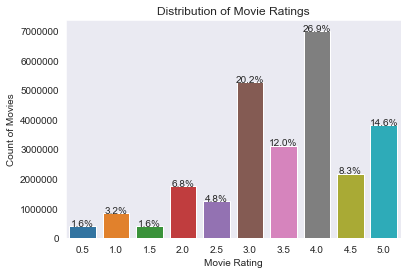

In [315]:
# Ratings Histogram:
sns.set_style("dark")
ax = sns.countplot(x="rating", data=ratings)
total = float(len(ratings))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 3,
            '{0:.1%}'.format(height/total),
            ha="center") 
ax.set_ylabel("Count of Movies")
ax.set_xlabel("Movie Rating")
ax.set_title("Distribution of Movie Ratings")
plt.show()

Examining the distribution of movie genre could be useful if we decide to get more sophisticated with our recommendation engine, if we branch out of user preferences (or if we're recommending to a new user), we might try to keep the movie recommendations in line with the overall genre distribution.

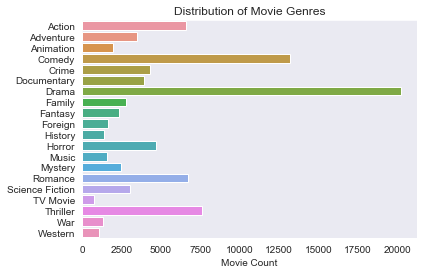

In [316]:
mlb = MultiLabelBinarizer()
genre_count = pd.DataFrame(mlb.fit_transform(movies['genres']),columns=mlb.classes_).sum()

ax = sns.barplot(genre_count.values, genre_count.index)
ax.set_xlabel("Movie Count")
ax.set_title("Distribution of Movie Genres")
plt.show()

The distribution of votes on each movie indicates that more users are willing to rate movies at a 0 than a 10, and the distribution is slightly left skewed, indicating users may be more likely to rate movies using the higher end of the scale.

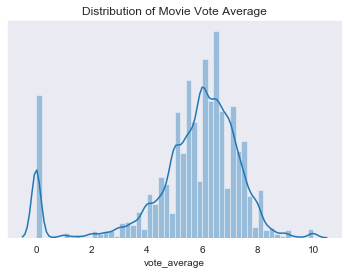

In [318]:
ax = sns.distplot(movies['vote_average'])
ax.set_ylabel("")
ax.set_yticks([])
ax.set_title("Distribution of Movie Vote Average")
plt.show()

## Top 10 Stats:
Below we'll list several top 10 statistics for movies.  For the most part, the stats will be the top 10 "blank" having the most movies.  The only exception to this is the top 10 movies by vote count.  The ordering is as follows:
* Actors with the most movies
* Genres with the most movies
* Directors with the most movies
* Producers with the most movies
* Collections with the most movies
* Original Languages with the most movies
* Spoken Languages with the most movies
* Highest rated movies by TMDB user votes (movies must have at least 1,000 votes)

In [467]:
def get_top10_list(column):
    mlb = MultiLabelBinarizer()
    if type(movies[column][0]) == list:
        return pd.DataFrame(mlb.fit_transform(movies[movies[column].str.len() > 0][column]),columns=mlb.classes_).sum().nlargest(n=10)
    else:
        return movies[movies[column].str.len() > 0][column].value_counts().nlargest(10)

In [415]:
get_top10_list('actors')

Bess Flowers         240
Christopher Lee      148
John Wayne           125
Samuel L. Jackson    123
Gérard Depardieu     110
Michael Caine        110
John Carradine       109
Donald Sutherland    108
Jackie Chan          108
Frank Welker         104
dtype: int64

In [416]:
get_top10_list('genres')

Drama              20244
Comedy             13176
Thriller            7619
Romance             6730
Action              6592
Horror              4671
Crime               4304
Documentary         3930
Adventure           3490
Science Fiction     3044
dtype: int64

In [418]:
get_top10_list('directors')

Charles Lang           77
John Ford              68
Harry Stradling Sr.    66
Michael Curtiz         65
William H. Daniels     65
James Wong Howe        59
Douglas Shearer        55
Werner Herzog          55
Joseph F. Biroc        54
Alfred Hitchcock       53
dtype: int64

In [468]:
get_top10_list('producers')

Hal B. Wallis       131
Darryl F. Zanuck    119
Roger Corman        114
Harvey Weinstein    113
Bob Weinstein       111
Scott Rudin          81
Steven Spielberg     79
Arnon Milchan        78
Tim Bevan            76
Walt Disney          74
dtype: int64

In [465]:
get_top10_list('belongs_to_collection')

The Bowery Boys                           29
Totò Collection                           27
Zatôichi: The Blind Swordsman             26
James Bond Collection                     26
The Carry On Collection                   25
Charlie Chan (Sidney Toler) Collection    21
Pokémon Collection                        20
Godzilla (Showa) Collection               16
Dragon Ball Z (Movie) Collection          15
Uuno Turhapuro                            15
Name: belongs_to_collection, dtype: int64

In [470]:
get_top10_list('original_language')

en    32251
fr     2436
it     1529
ja     1347
de     1079
es      994
ru      826
hi      508
ko      444
zh      409
Name: original_language, dtype: int64

In [485]:
get_top10_list('spoken_languages')

English      28727
Français      4193
Deutsch       2624
Español       2413
Italiano      2366
日本語           1756
Pусский       1563
普通话            790
हिन्दी         706
Português      591
dtype: int64

In [511]:
movies[movies['vote_count'] > 999].nlargest(10, 'vote_average')[['title','vote_average','vote_count']]

,title,vote_average,vote_count
314,The Shawshank Redemption,8.5,8358.0
834,The Godfather,8.5,6024.0
40222,Your Name.,8.5,1030.0
292,Pulp Fiction,8.3,8670.0
522,Schindler's List,8.3,4436.0
1152,One Flew Over the Cuckoo's Nest,8.3,3001.0
1176,Psycho,8.3,2405.0
1178,The Godfather: Part II,8.3,3418.0
1184,Once Upon a Time in America,8.3,1104.0
2210,Life Is Beautiful,8.3,3643.0


In [469]:
list(movies.columns)

['adult',
 'belongs_to_collection',
 'budget',
 'genres',
 'homepage',
 'id',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'video',
 'vote_average',
 'vote_count',
 'keywords',
 'directors',
 'producers',
 'actors']

In [500]:
movies.vote_count

0        5415.0
1        2413.0
2          92.0
3          34.0
4         173.0
          ...  
45428       1.0
45429       3.0
45430       6.0
45431       0.0
45432       0.0
Name: vote_count, Length: 45433, dtype: float64

# Modeling and Evaluation 1

Train and adjust parameters


# Modeling and Evaluation 2

Evaluate and Compare

# Modeling and Evaluation 3

Visualize Results

# Modeling and Evaluation 4

Summarize the Ramifications

# Deployment

Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

# Exceptional Work

You have free reign to provide additional analyses or combine analyses.

# References

1. Dataset obtained from kaggle : <a href="https://www.kaggle.com/rounakbanik/the-movies-dataset"> click here </a>
2. Apple (turicreate) <a href="https://apple.github.io/turicreate/docs/userguide/recommender/"> article </a> on Recommender. 
3. Recommendor Systems instruction by Dr. Eric Larson: <a href="https://www.youtube.com/watch?v=I-xPNMCqW2o"> video </a>
4. Movie Recommendation System with Collaborative Filteringn by Code Heroku: <a href="https://www.youtube.com/watch?v=3ecNC-So0r4&t=903s"> video </a>